# MQ-3 

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  200kOhm
    Rh (Heater Resistance)     :  33 ohm +/- 5%
    Ph (Heating consumption)   :  less than 750mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 1MOhm  -  8MOhm (0.4mg/L alcohol)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration  Scope:
        Alcohol                :  0.05mg/L  - 10 mg/L


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet

POINTS = {
    'alcohol' : {
        'p1': {'x': 0.100,  'y': 2.332},
        'p2': {'x': 0.216,  'y': 1.539},
        'p3': {'x': 0.402,  'y': 1.025},
        'p4': {'x': 1.008,  'y': 0.542},
        'p5': {'x': 1.646,  'y': 0.396},
        'p6': {'x': 2.535,  'y': 0.289},
        'p7': {'x': 3.998,  'y': 0.206},
        'p8': {'x': 6.044,  'y': 0.163},
        'p9': {'x': 8.090,  'y': 0.131}, 
        'p10':{'x': 10.000, 'y': 0.114}, 
    },
    'benzine' : {
        'p1': {'x': 0.100,  'y': 4.133},
        'p2': {'x': 0.214,  'y': 3.192},
        'p3': {'x': 0.409,  'y': 2.581},
        'p4': {'x': 1.030,  'y': 1.767},
        'p5': {'x': 1.650,  'y': 1.469},
        'p6': {'x': 2.535,  'y': 1.222},
        'p7': {'x': 4.084,  'y': 1.025},
        'p8': {'x': 6.207,  'y': 0.917},
        'p9': {'x': 8.047,  'y': 0.821}, 
        'p10':{'x': 10.000, 'y': 0.784}, 
    },
    # Methane
    'ch4' : {
        'p1': {'x': 0.100,  'y': 49.566},
        'p2': {'x': 0.217,  'y': 48.659},
        'p3': {'x': 0.412,  'y': 46.464},
        'p4': {'x': 1.035,  'y': 44.778},
        'p5': {'x': 1.650,  'y': 42.365},
        'p6': {'x': 2.535,  'y': 42.758},
        'p7': {'x': 4.105,  'y': 41.590},
        'p8': {'x': 6.207,  'y': 40.453},
        'p9': {'x': 8.090,  'y': 40.453}, 
        'p10':{'x': 10.000, 'y': 39.713}, 
    },
    'hexane' : {
        'p1': {'x': 0.100,  'y': 51.432},
        'p2': {'x': 0.217,  'y': 39.713},
        'p3': {'x': 0.414,  'y': 30.949},
        'p4': {'x': 1.041,  'y': 22.609},
        'p5': {'x': 6.207,  'y': 12.520},
        'p6': {'x': 8.090,  'y': 11.001},
        'p7': {'x': 10.000, 'y': 10.031},
    },
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 0.100,  'y': 51.432},
        'p2': {'x': 0.216,  'y': 43.959},
        'p3': {'x': 0.414,  'y': 36.210},
        'p4': {'x': 1.041,  'y': 29.826},
        'p5': {'x': 6.240,  'y': 16.065},
        'p6': {'x': 8.047,  'y': 13.987},
        'p7': {'x': 10.000, 'y': 13.111},
    },
    # Carbon Monoxide
    'co' : {
        'p1': {'x': 0.100,  'y': 51.909},
        'p2': {'x': 0.216,  'y': 45.613},
        'p3': {'x': 0.414,  'y': 41.975},
        'p4': {'x': 1.035,  'y': 33.943},
        'p5': {'x': 6.174,  'y': 20.237},
        'p6': {'x': 8.026,  'y': 18.198},
        'p7': {'x': 10.000, 'y': 16.214},
    }  
}


AIR = 60

GASES = ['alcohol', 'benzine', 'ch4', 'hexane', 'lpg', 'co']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# mg/L value calculation 
MgL   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

# PPM value calculation 
PPM   = lambda y, m, b: MgL(y, m, b) * 1000

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq3_1", "mq3_2"]
df = pd.read_csv('RoomInNormalDay_Jun[14 - 15].csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq3_1 = df[["date","mq3_1"]]
mq3_2 = df[["date","mq3_2"]]

### Ro values to be considered

- __Sensor 1__: 1.500 kOhms
- __Sensor 2__: 1.569 kOhms

In [7]:
### MQ 3 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 1.569  #kOhms 

# MQ 3 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 1.500  #kOhms 

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq3_1['mq3_1'].min(),
    mq3_1['mq3_1'].mean(), 
    mq3_1['mq3_1'].quantile(0.25),
    mq3_1['mq3_1'].quantile(0.5),
    mq3_1['mq3_1'].quantile(0.75),
    mq3_1['mq3_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq3_2['mq3_2'].min(),
    mq3_2['mq3_2'].mean(), 
    mq3_2['mq3_2'].quantile(0.25),
    mq3_2['mq3_2'].quantile(0.5),
    mq3_2['mq3_2'].quantile(0.75),
    mq3_2['mq3_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))
    

In [10]:
print(f"Period in which the readings were carried out:\
{mq3_1['date'].min()} - {mq3_1['date'].max()} \n")


print("Sensor 1")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
    
print("-"*(12*7))

print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))


Period in which the readings were carried out:2022-06-14 09:56:00 - 2022-06-15 16:23:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        53.754       43.222       49.534       45.026       38.51        31.564      
ALCOHOL      0.298        0.447        0.347        0.414        0.554        0.801       
BENZINE      0.052        0.1          0.067        0.088        0.14         0.251       
CH4          3.329        1393.914     102.721      902.107      14234.499    139665.188  
HEXANE       87.609       168.376      111.923      148.968      234.998      393.427     
LPG          80.528       228.602      120.251      192.037      336.717      795.279     
CO           81.221       329.203      132.168      239.064      600.362      1330.22     
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           M

In [11]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

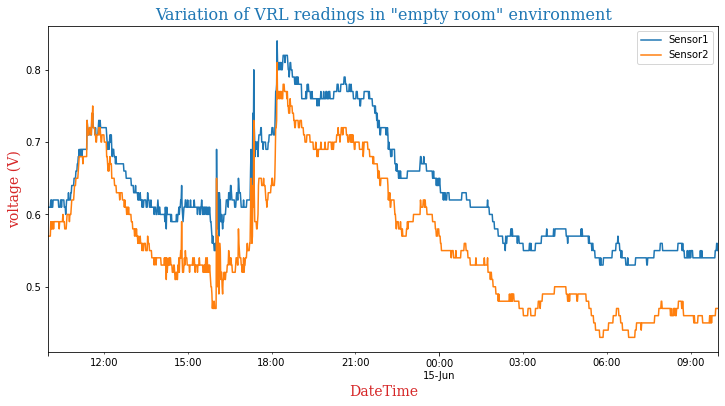

In [12]:
fdf = df[(df['date'] > '6/14/22 10:00 AM') & (df['date'] < '6/15/22 010:00 AM')]

ax = fdf.plot(x='date', y=["mq3_1","mq3_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 3 Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq3_1["mq3_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq3_1[gas] = ppm1[gas]

In [14]:
# MQ 3 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq3_2["mq3_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

 
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq3_2[gas] = ppm2[gas]

In [15]:
mq3_1.describe()

,mq3_1,alcohol,benzine,ch4,hexane,lpg,co
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.642544,0.456159,0.106040,10271.066002,176.705584,242.343932,383.898532
std,0.078189,0.120096,0.044827,17604.624655,72.041445,138.356384,290.918560
min,0.530000,0.298476,0.052369,3.329314,87.609187,80.527502,81.221484
25%,0.570000,0.347294,0.066623,102.721068,111.922689,120.250563,132.167822
50%,0.620000,0.414475,0.088242,902.106607,148.968416,192.036589,239.064144
75%,0.710000,0.553718,0.139822,14234.499086,234.997587,336.717315,600.362131
max,0.840000,0.800503,0.251167,139665.187872,393.426719,795.279305,1330.220404


In [16]:
mq3_2.describe()

,mq3_2,alcohol,benzine,ch4,hexane,lpg,co
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.577309,0.339631,0.067832,2226.178308,114.026040,132.410891,188.297332
std,0.094787,0.117127,0.036841,4798.481471,62.507866,104.494980,194.575238
min,0.430000,0.178913,0.023219,0.000031,38.298245,20.777558,15.676935
25%,0.490000,0.233559,0.035465,0.012915,58.929753,42.072623,36.924678
50%,0.560000,0.307925,0.055028,6.742065,92.137399,87.453206,89.780021
75%,0.670000,0.449740,0.100468,1431.861505,169.993273,231.061952,337.527415
max,0.810000,0.679391,0.193528,50547.493628,312.794246,522.086404,966.554832


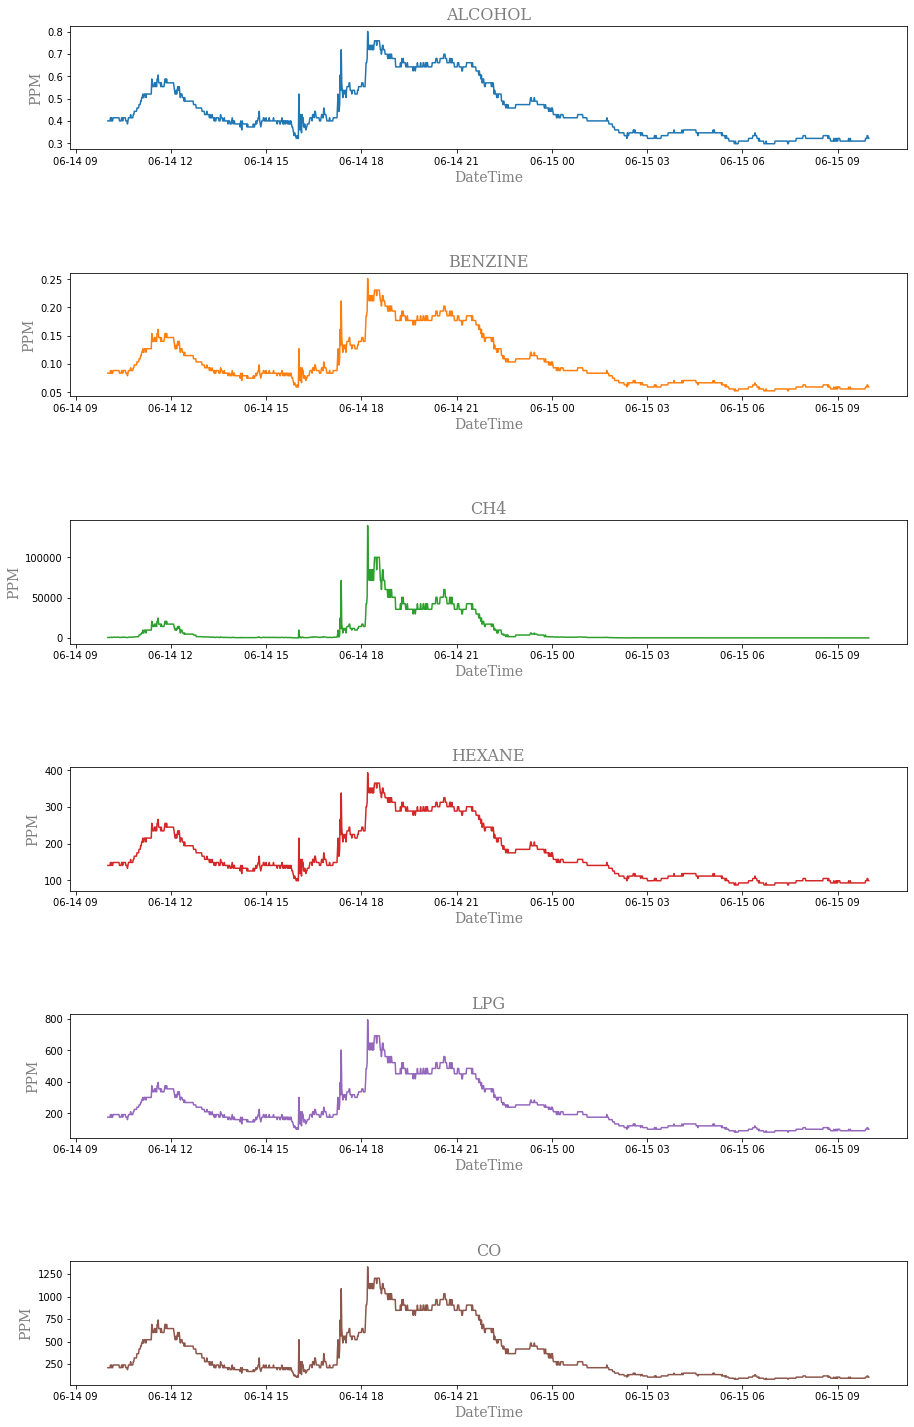

In [17]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq3_1[(mq3_1['date'] > '6/14/22 10:00 AM') & (mq3_1['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


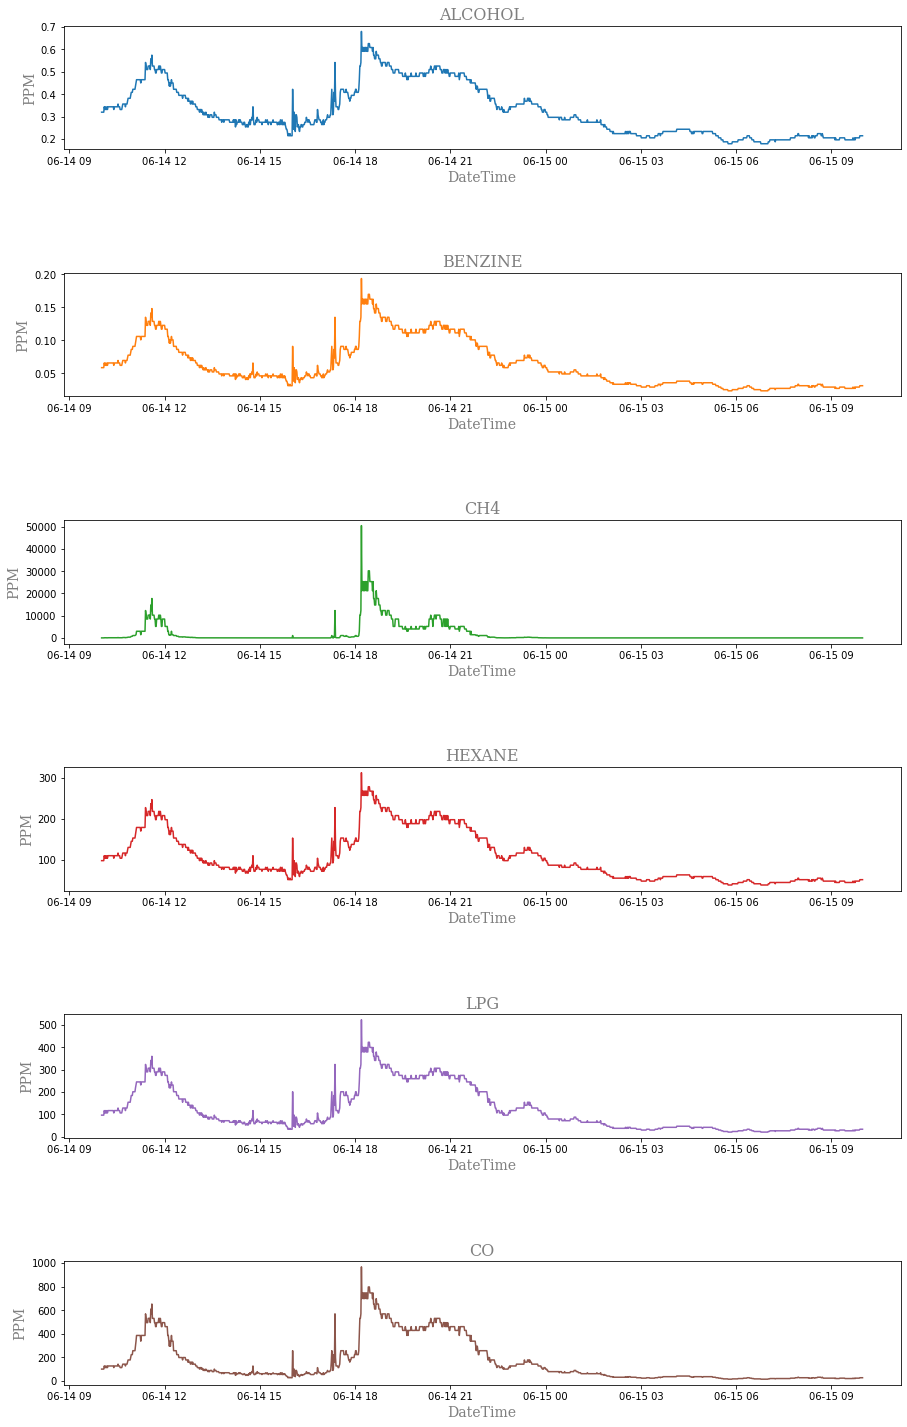

In [18]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq3_2[(mq3_2['date'] > '6/14/22 10:00 AM') & (mq3_2['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()


In [19]:
# Save in excel file
mq3_1.to_csv('mq3_1.csv')
mq3_2.to_csv('mq3_2.csv')